In [51]:
%load_ext autoreload
%autoreload 2

import os
import time
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import sys

from copy import deepcopy
from collections import namedtuple

from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

import pydrake
from pydrake.all import (
    AngleAxis,
    CommonSolverOption,
    MathematicalProgram,
    MakeSolver,
    RandomGenerator,
    RigidTransform,
    RollPitchYaw,
    RotationMatrix,
    GurobiSolver,
    Solve,
    SolverOptions,
    VPolytope,
    MixedIntegerRotationConstraintGenerator,
    IntervalBinning,
    UniformlyRandomRotationMatrix
)

import meshcat
import meshcat.geometry as meshcat_geom

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()

base_url = "http://lab.protos.us.to"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))

Meshcat url:  http://lab.protos.us.to:7012/static/


In [68]:
vis["test_tree"]["test1"]["test2"].set_transform(np.eye(4))
vis.delete()

In [38]:
from simple_3d_ssg import *
from ssg_test_grammar_sink import *
from ssg_test_grammar_oriented_clusters import *
from ssg_test_grammar_rotation import *

#root_node = OrientedClusterRoot
#root_node = RotationTestRoot
root_node = Sink
root_tf = RigidTransform()

In [39]:
np.random.seed(45)
random.seed(45)
observed_tree = sample_tree(root_node, root_tf)
observed_nodes = get_observed_nodes(observed_tree)
for n in observed_tree.nodes:
    print(n, n.tf.translation(), n.tf.rotation())
draw_tree(observed_tree, vis, prefix="gt/", draw_regions=False)

<ssg_test_grammar_sink.Sink object at 0x7f8e04127ef0> [0. 0. 0.] RotationMatrix([
  [1.0, 0.0, 0.0],
  [0.0, 1.0, 0.0],
  [0.0, 0.0, 1.0],
])
<ssg_test_grammar_sink.Plates object at 0x7f8e04127710> [0. 0. 0.] RotationMatrix([
  [1.0, 0.0, 0.0],
  [0.0, 1.0, 0.0],
  [0.0, 0.0, 1.0],
])
<ssg_test_grammar_sink.Mugs object at 0x7f8e04127f60> [0. 0. 0.] RotationMatrix([
  [1.0, 0.0, 0.0],
  [0.0, 1.0, 0.0],
  [0.0, 0.0, 1.0],
])
<ssg_test_grammar_sink.Plate object at 0x7f8e04127e48> [0.60191335 0.78494564 0.        ] RotationMatrix([
  [-0.9983011893030314, -0.05826435819738557, 0.0],
  [0.05826435819738557, -0.9983011893030314, 0.0],
  [0.0, 0.0, 1.0],
])
<ssg_test_grammar_sink.Mug object at 0x7f8e04127860> [0.59463559 0.32613377 0.        ] RotationMatrix([
  [0.46477281954240907, -0.8854299668605075, 0.0],
  [0.8854299668605075, 0.46477281954240907, 0.0],
  [0.0, 0.0, 1.0],
])
<ssg_test_grammar_sink.Mug object at 0x7f8e04127e80> [0.45242471 0.33174987 0.        ] RotationMatrix([
  [-0.7

# MIP Scene Parsing for this grammar

We're given the grammar description (implicit in the node definitions); can we recover a MAP parse tree?

Same logic as previous MIP parsing: create the super tree for the grammar (cutting off recursive rules at a max recursion depth), and create decision variables for each possible node location and activation. Impose feasibility constraints on each parent/child pair:
- Child activation implies parent activation
- If the parent is an AND node and is active, all children are active.
- If the parent is an OR node and is active, exactly one child is active.

Impose additional symmetry breaking constraints:
- Prefer children activate in left-to-right order, and are assigned ascending poses in the x coordinate (symmetry breaking).


Super tree has 109 nodes


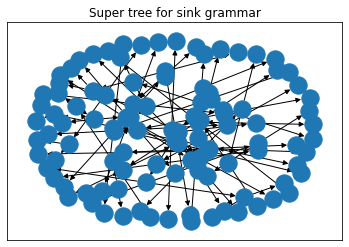

In [47]:
def make_super_tree(root_node_type, max_recursion_depth=15):
    # Forms a graph of nodes for which any actual sampled tree would be a subgraph.
    # (TF's are all set to 0.)
    tree = nx.DiGraph()
    root = root_node_type(tf = RigidTransform())
    root.__recursion_depth = 0
    tree.add_node(root)
    node_queue = [root]
    while len(node_queue) > 0:
        parent = node_queue.pop(0)
        if isinstance(parent, (AndNode, OrNode)):
            maximal_children = [ci.child_type for ci in parent.child_infos]
        elif isinstance(parent, GeometricSetNode):
            maximal_children = [parent.child_infos[0].child_type for k in range(parent.max_children)]
        elif isinstance(parent, TerminalNode):
            maximal_children = []
        else:
            raise ValueError(type(parent))

        for child_type in maximal_children:
            child = child_type(tf = RigidTransform())
            child.__recursion_depth = parent.__recursion_depth + 1
            if child.__recursion_depth <= max_recursion_depth:
                tree.add_node(child)
                tree.add_edge(parent, child)
                node_queue.append(child)
    return tree

super_tree = make_super_tree(root_node)
nx.draw_networkx(super_tree, with_labels=False)
plt.title("Super tree for sink grammar")
print("Super tree has %d nodes" % len(list(super_tree.nodes)))

In [48]:
def infer_mle_tree(root_node_type, root_tf, observed_nodes, verbose=False):
    start_time = time.time()
    if verbose:
        print("Starting setup.")

    super_tree = make_super_tree(root_node_type)
    observed_nodes = deepcopy(observed_nodes)

    prog = MathematicalProgram()

    # Every node gets a binary variable to indicate
    # whether it's active or node. This is equivalent to a
    # binary variable on the incoming edge for the node.
    active_vars = prog.NewBinaryVariables(len(super_tree.nodes), "nodes_active")
    for k, node in enumerate(super_tree.nodes):
        node.active = active_vars[k]

    if verbose:
        print("Activation vars allocated.")

    # Every node gets an optimized pose.
    mip_rot_gen = MixedIntegerRotationConstraintGenerator(
        approach = MixedIntegerRotationConstraintGenerator.Approach.kBilinearMcCormick,
        num_intervals_per_half_axis=2,
        interval_binning = IntervalBinning.kLogarithmic
    )
    for node_k, node in enumerate(super_tree.nodes):
        node.R_optim = prog.NewContinuousVariables(3, 3, "%s_%03d_R" % (node.__class__.__name__, node_k))
        # Trivial constraints
        prog.AddBoundingBoxConstraint(-np.ones(9), np.ones(9), node.R_optim.flatten())
        # Delay adding these to the program; we don't need them
        # until we know that the rotation is unconstrained in some way.
        #mip_rot_gen.AddToProgram(node.R_optim, prog)
        node.t_optim = prog.NewContinuousVariables(3, "%s_%03d_t" % (node.__class__.__name__, node_k))
        
    if verbose:
        print("Continuous variables allocated.")

    # Constraint root node to have the grammar's root position.
    root_node = get_tree_root(super_tree)
    prog.AddBoundingBoxConstraint(
        root_tf.translation(), root_tf.translation(),
        root_node.t_optim
    )
    R_target = root_tf.rotation().matrix()
    for i in range(3):
        for j in range(3):
            prog.AddBoundingBoxConstraint(
                R_target[i, j], R_target[i, j],
                root_node.R_optim[i, j]
            )

    ## For each node in the super tree, add relationships between the parent
    ## and that node.
    for parent_node in super_tree:
        children = list(super_tree.successors(parent_node))
        child_actives = [c.active for c in children]
        parent_node.child_actives = child_actives

        # Children active requires parent active.
        for child_active in child_actives:
            prog.AddLinearConstraint(parent_node.active >= child_active)

        ## Parent/child activation relationships and symmetry breaking.
        if isinstance(parent_node, GeometricSetNode):
            # Geometric node child ordering to reduce duplicate parse: a child can
            # only be active if the previous child is also active.
            for k in range(len(child_actives) - 1):
                # child_{k+1} implies child_k
                # i.e. child_k >= child_{k+1}
                prog.AddLinearConstraint(child_actives[k] >= child_actives[k+1])

            # Child supports should be ordered, to break symmetries.
            # TODO(gizatt) Does this apply to AND nodes? I don't think so, since
            # each node under an AND node has its own distribution. But I could conceivably
            # detect "equivalent" children and break symmetries there.
            for child, next_child in zip(children[:-1], children[1:]):
                prog.AddLinearConstraint(next_child.t_optim[0] >= child.t_optim[0])

            # The geometric process we used (np.random.geometric) is only supported
            # on k=1, ..., so constrain that the # of active children must be
            # nonzero if this node is on.
            if len(child_actives) > 0:
                prog.AddLinearConstraint(sum(child_actives) >= parent_node.active)

        elif isinstance(parent_node, AndNode):
            # All children should be on if the parent node is on.
            for k in range(len(child_actives)):
                prog.AddLinearConstraint(child_actives[k] >= parent_node.active)

        elif isinstance(parent_node, OrNode):
            # Exactly one child can be on if the parent is on.
            prog.AddLinearConstraint(sum(child_actives) == parent_node.active)

        elif isinstance(parent_node, TerminalNode):
            pass
        
        else:
            raise ValueError("Unexpected node type: ", type(parent_node))
        

        ## Child location constraints relative to parent.
        for child_k, child_node in enumerate(children):
            if isinstance(parent_node, (AndNode, OrNode)):
                child_info = parent_node.child_infos[child_k]
            elif isinstance(parent_node, GeometricSetNode):
                child_info = parent_node.child_infos[0]
            else:
                raise ValueError("Unexpected node type for child info retrieval: ", type(parent_node))

            # Child translation should be within relative translation bounds of parent, in
            # the frame of the parent.
            # TODO: CAN'T DO LOCAL FRAME CONSTRAINT DUE TO ROTATION OF CONSTRAINT CAUSING
            # SIGN FLIPS. NEED SOME KIND OF SOLUTION...
            lb_world = child_info.child_xyz_bounds.xyz_min + parent_node.t_optim
            ub_world = child_info.child_xyz_bounds.xyz_max + parent_node.t_optim
            # X should be within a half-bound-width of the centerl.
            for k in range(3):
                prog.AddLinearConstraint(child_node.t_optim[k] >= lb_world[k])
                prog.AddLinearConstraint(child_node.t_optim[k] <= ub_world[k])

            # Short-circuit if the rotation is unconstrained.
            if child_info.child_rotation_bounds is None:
                # Any rotation will do, but it needs to be a real rotation if it's not an observed node.
                if not child_node.observed:
                    mip_rot_gen.AddToProgram(child_node.R_optim, prog)
            else:
                axis = child_info.child_rotation_bounds.axis
                min_angle = child_info.child_rotation_bounds.min_angle
                max_angle = child_info.child_rotation_bounds.max_angle
                assert min_angle <= max_angle
                if min_angle == max_angle:
                    # Short-circuit if the rotation is exactly constrained relative to parent rotation.
                    relative_rotation = RotationMatrix(AngleAxis(max_angle, axis)).matrix()
                    target_rotation = parent_node.R_optim.dot(relative_rotation)
                    for i in range(3):
                        for j in range(3):
                            prog.AddLinearEqualityConstraint(child_node.R_optim[i, j] == target_rotation[i, j])
                else:
                    # Rotation will be partially unconstrained; need to make sure it's a real rotation
                    # if it's not observed.
                    if not child_node.observed:
                        mip_rot_gen.AddToProgram(child_node.R_optim, prog)
                    
                    # Child rotation should be within a relative rotation of the parent around
                    # the specified axis, and the axis should *not* be rotated between the
                    # parent and child frames. This is similar to the revolute joint constraints
                    # used by Hongkai Dai in his global IK formulation.
                    # (1): The direction of the rotation axis doesn't change between
                    # parent and child frames.
                    # The axis is the same in both the parent and child frame
                    # (see https://drake.mit.edu/doxygen_cxx/classdrake_1_1multibody_1_1_revolute_joint.html).
                    # Though there may be an additional offset according to the axis offset
                    # in the parent and child frames.
                    #axis_offset_in_parent = RigidTransform()
                    #axis_offset_in_child = RigidTransform()
                    parent_view_of_axis_in_world = parent_node.R_optim.dot(axis)
                    child_view_of_axis_in_world = child_node.R_optim.dot(axis)
                    for k in range(3):
                        prog.AddLinearEqualityConstraint(
                            parent_view_of_axis_in_world[k] == child_view_of_axis_in_world[k]
                        )
                    
                    # Short-circuit if there is no rotational constraint other than axis alignment.
                    if max_angle - min_angle < 2.*np.pi:
                        # (2): Eq(10) in the global IK paper. Following implementation in
                        # https://github.com/RobotLocomotion/drake/blob/master/multibody/inverse_kinematics/global_inverse_kinematics.cc
                        # First generate a vector normal to the rotation axis via cross products.
                        v_c = np.cross(axis, np.array([0., 0., 1.]))
                        if np.linalg.norm(v_c) <= np.sqrt(2)/2:
                            # Axis is too close to +z; try a different axis.
                            v_c = np.cross(axis, np.array([0., 1., 0.]))
                        v_c = v_c / np.linalg.norm(v_c)
                        # TODO: Hongkai uses multiple perpendicular vectors. Worth a try?

                        # Translate into a symmetric bound by finding a rotation to
                        # "center" us in the bound region, and the symmetric bound size alpha.
                        # -alpha <= theta - (a+b)/2 <= alpha
                        # where alpha = (b-a) / 2
                        alpha = (max_angle - min_angle) / 2.
                        offset_angle = (max_angle + min_angle) / 2.
                        R_offset = RotationMatrix(AngleAxis(offset_angle, axis)).matrix()
                        # |R_WC*R_CJc*v - R_WP * R_PJp * R(k,(a+b)/2)*v | <= 2*sin (α / 2) in
                        # global ik code; for us, I'm assuming the joint frames are aligned with
                        # the body frames, so R_CJc and R_PJp are identitiy.
                        lorentz_bound = 2 * np.sin(alpha / 2.)
                        vector_diff = (
                            child_node.R_optim.dot(v_c) - 
                            parent_node.R_optim.dot(R_offset).dot(v_c)
                        )
                        # TODO: Linear approx?
                        prog.AddLorentzConeConstraint(np.r_[lorentz_bound, vector_diff])

    # For each observed node, add a binary variable for each possible
    # correspondence to a node in the observed set, where an active correspondence
    # forces the corresponded node to be the same position as the observed node.
    for n in super_tree:
        # (first prep some bookkeeping)
        n.outgoings = []
    for observed_node in observed_nodes:
        possible_sources = [n for n in super_tree if type(n) == type(observed_node)]
        source_actives = prog.NewBinaryVariables(len(possible_sources), observed_node.__class__.__name__ + "_sources")

        # Store these variables
        observed_node.source_actives = source_actives
        for k, n in enumerate(possible_sources):
            n.outgoings.append(source_actives[k])

        # Each observed node needs exactly one explaining input.
        prog.AddLinearEqualityConstraint(sum(source_actives) == 1)

        for k, node in enumerate(possible_sources):
            M = 10. # Should upper bound positional error in any single dimension
            # When correspondence is active, force the node to match the observed node.
            # Otherwise, it can vary within a big M of the observed node.
            obs_t = observed_node.tf.translation()
            obs_R = observed_node.tf.rotation().matrix()
            for i in range(3):
                prog.AddLinearConstraint(node.t_optim[i] <= obs_t[i] + 1E-6 + (1. - source_actives[k]) * M)
                prog.AddLinearConstraint(node.t_optim[i] >= obs_t[i] - 1E-6 - (1. - source_actives[k]) * M)
            M = 2. # Max error in a rotation matrix entry
            for i in range(3):
                for j in range(3):
                    prog.AddLinearConstraint(node.R_optim[i, j] <= obs_R[i, j] + 1E-6 + (1. - source_actives[k]) * M)
                    prog.AddLinearConstraint(node.R_optim[i, j] >= obs_R[i, j] - 1E-6 - (1. - source_actives[k]) * M)

    # Go back and make sure no node in the super tree is being used
    # to explain more than one observed node, and that the "observed"
    # nodes are only active if they are explaining something.
    # TODO(gizatt) These constraints are a little frustrating: without
    # them, the parsing likes to hallucinate unnecessary hidden nodes
    # since adding them increases the tree likelihood (since the net log-prob
    # of adding a new node is positive due to concentrated densities).
    # It makes me feel like I'm doing something fundamentally wrong, like using
    # total model prob to do model comparisons between models of different size.
    for node in super_tree:
        if node.observed:
            if len(node.outgoings) > 0:
                prog.AddLinearConstraint(sum(node.outgoings) <= 1)
                prog.AddLinearConstraint(node.active == sum(node.outgoings))
            else:
                # Never observed this type in the scene, so this node can't be active.
                prog.AddLinearConstraint(node.active == 0)
            
    # Finally, build the objective.
    for parent_node in super_tree:
        # For the discrete states, do maximum likelihood.
        children = list(super_tree.successors(parent_node))
        if isinstance(parent_node, (AndNode, TerminalNode)):
            pass
        elif isinstance(parent_node, OrNode):
            # Binary variables * log of probabilities.
            for p, child in zip(parent_node.child_probs, children):
                prog.AddLinearCost(-np.log(p) * child.active)
        elif isinstance(parent_node, GeometricSetNode):
            p = parent_node.p
            for child in children:
                prog.AddLinearCost(-np.log(1.-p) * child.active)            
        else:
            raise ValueError("Unexpected node in cost assembly: ", type(parent_node))

        # TODO: Continuous cost?

    solver = GurobiSolver()
    options = SolverOptions()
    logfile = "/tmp/gurobi.log"
    os.system("rm %s" % logfile)
    options.SetOption(solver.id(), "LogFile", logfile)
    setup_time = time.time()
    if verbose:
        print("Setup time: ", setup_time - start_time)
        print("Num vars: ", prog.num_vars())
        print("Num constraints: ", sum([c.evaluator().num_constraints() for c in prog.GetAllConstraints()]))
        sys.stdout.flush()
    result = solver.Solve(prog, None, options)
    solve_time = time.time() 
    if verbose:
        print("Solve time: ", solve_time-setup_time)
        print("Total time: ", solve_time - start_time)
        print("Optimization success?: ", result.is_success())
        print("Logfile: ")
        with open(logfile) as f:
            print(f.read())
    TreeInferenceResults = namedtuple("TreeInferenceResults", ["optim_result", "super_tree", "observed_nodes"])
    return TreeInferenceResults(result, super_tree, observed_nodes)


start_time = time.time()
inference_results = infer_mle_tree(
    root_node, root_tf, observed_nodes, verbose=True
)
elapsed = time.time() - start_time
print("Took %f secs" % elapsed)

Starting setup.
Activation vars allocated.
Continuous variables allocated.
Setup time:  1.4892926216125488
Num vars:  6888
Num constraints:  31155
Solve time:  0.3507707118988037
Total time:  1.8400633335113525
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Fri Aug 20 12:14:16 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 25241 rows, 6928 columns and 124148 nonzeros
Model fingerprint: 0x754a9e23
Model has 10 quadratic constraints
Variable types: 6253 continuous, 675 integer (675 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [4e-01, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 1e+01]
Presolve removed 24930 rows and 6705 columns
Presolve time: 0.17s
Presolved: 311 rows, 223 columns, 2181 nonzeros
Presolved model has 2 quadratic constraint(s)
Variable types: 211 continuous, 12 integer (12 binary)

Root relaxation: objective 

In [49]:
def get_optimized_tree(inference_results, ax=None):
    ''' From the specified inference results, extract the scene tree. '''
    # Grab that supertree from optimization
    optim_result = inference_results.optim_result
    super_tree = inference_results.super_tree
    observed_nodes = inference_results.observed_nodes

    # Sanity-check observed nodes are explained properly.
    for observed_node in observed_nodes:
        if not np.isclose(np.sum(optim_result.GetSolution(observed_node.source_actives)), 1.):
            print("WARN: observed node %s not explained by MLE sol." % observed_node.tf)

    optimized_tree = nx.DiGraph()
    for node in super_tree:
        if optim_result.GetSolution(node.active):
            optimized_tree.add_node(node)
            # May have to post-process R to closest good R?
            node.tf = RigidTransform(
                p=optim_result.GetSolution(node.t_optim),
                R=RotationMatrix(optim_result.GetSolution(node.R_optim))
            )
            parents = list(super_tree.predecessors(node))
            assert len(parents) <= 1
            if len(parents) == 1:
                parent = parents[0]
                assert parent.active
                optimized_tree.add_edge(parent, node)
    return optimized_tree

optimized_tree = get_optimized_tree(inference_results)
draw_tree(optimized_tree, vis, prefix="optimized/", draw_regions=False)

[[ 1.    0.    0.    0.5 ]
 [ 0.    1.    0.    0.5 ]
 [ 0.    0.    1.   -0.05]
 [ 0.    0.    0.    1.  ]]
[[-9.89889895e-04 -8.68470171e-21  1.41831942e-04  2.36514123e-01]
 [ 1.41829942e-04 -6.06132746e-20  9.89889895e-04  7.47831362e-01]
 [ 0.00000000e+00  1.00000000e-03  6.12323400e-20  2.50000000e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-9.73354081e-04 -1.40412205e-20  2.29310533e-04  6.60998489e-01]
 [ 2.29310533e-04 -5.96007480e-20  9.73354081e-04  7.82907413e-01]
 [ 0.00000000e+00  1.00000000e-03  6.12323400e-20  2.50000000e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.72170615e-04  1.43448284e-20 -2.34268826e-04  8.30820515e-01]
 [-2.34268826e-04  5.95282816e-20 -9.72170615e-04  6.20146331e-01]
 [ 0.00000000e+00  1.00000000e-03  6.12323400e-20  2.50000000e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 0.47738158  0.87869455  0.          0.19864136]
 [-0.87869455  0.47738158  0.    

In [50]:
np.random.seed(45)
random.seed(45)
for k in range(20):
    observed_tree = sample_tree(root_node, root_tf)
    observed_nodes = get_observed_nodes(observed_tree)

    start_time = time.time()
    inference_results = infer_mle_tree(
        root_node, root_tf, observed_nodes, verbose=True
    )
    assert inference_results.optim_result.is_success()
    elapsed = time.time() - start_time
    print("Took %f secs" % elapsed)

Starting setup.
Activation vars allocated.
Continuous variables allocated.
Setup time:  0.9550333023071289
Num vars:  6527
Num constraints:  22480
Solve time:  0.28330135345458984
Total time:  1.2383346557617188
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Fri Aug 20 12:14:29 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 16566 rows, 6567 columns and 105737 nonzeros
Model fingerprint: 0x26acca0b
Model has 10 quadratic constraints
Variable types: 6253 continuous, 314 integer (314 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [4e-01, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 1e+01]
Presolve removed 16255 rows and 6344 columns
Presolve time: 0.14s
Presolved: 311 rows, 223 columns, 2181 nonzeros
Presolved model has 2 quadratic constraint(s)
Variable types: 211 continuous, 12 integer (12 binary)

Root relaxation: objective

Setup time:  1.0282416343688965
Num vars:  6572
Num constraints:  23566
Solve time:  0.2928457260131836
Total time:  1.32108736038208
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Fri Aug 20 12:14:36 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 17652 rows, 6612 columns and 108032 nonzeros
Model fingerprint: 0xf1786e91
Model has 10 quadratic constraints
Variable types: 6253 continuous, 359 integer (359 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [4e-01, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 1e+01]
Presolve removed 17341 rows and 6389 columns
Presolve time: 0.15s
Presolved: 311 rows, 223 columns, 2181 nonzeros
Presolved model has 2 quadratic constraint(s)
Variable types: 211 continuous, 12 integer (12 binary)

Root relaxation: objective 9.902883e+00, 89 iterations, 0.00 seconds

    Nodes    |    Current Node    


Gurobi 9.0.2 (linux64) logging started Fri Aug 20 12:14:43 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 20076 rows, 6713 columns and 113183 nonzeros
Model fingerprint: 0xc8520183
Model has 10 quadratic constraints
Variable types: 6253 continuous, 460 integer (460 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [4e-01, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 1e+01]
Presolve removed 19759 rows and 6485 columns
Presolve time: 0.16s
Presolved: 317 rows, 228 columns, 2202 nonzeros
Presolved model has 2 quadratic constraint(s)
Variable types: 216 continuous, 12 integer (12 binary)

Root relaxation: objective 1.026753e+01, 74 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      10.2675261   10.26753 

Took 1.582901 secs
Starting setup.
Activation vars allocated.
Continuous variables allocated.
Setup time:  1.0515823364257812
Num vars:  6586
Num constraints:  23885
Solve time:  0.29273438453674316
Total time:  1.3443167209625244
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Fri Aug 20 12:14:51 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 17966 rows, 6626 columns and 108741 nonzeros
Model fingerprint: 0x218c57bc
Model has 10 quadratic constraints
Variable types: 6253 continuous, 373 integer (373 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [4e-01, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 1e+01]
Presolve removed 17655 rows and 6403 columns
Presolve time: 0.14s
Presolved: 311 rows, 223 columns, 2181 nonzeros
Presolved model has 2 quadratic constraint(s)
Variable types: 211 continuous, 12 integer (12 binary)

Root re